In [1]:
# Importing libraries
import os
from tract_helpers import *
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
import regex as re

In [2]:
# Get paths, depending on whether we're in HPC or not
hpc = False
(ALL_DATA_FOLDER, SUBJECTS_FOLDER, DWI_OUTPUT_FOLDER, DWI_MAIN_FOLDER, 
    T1_MAIN_FOLDER, FMRI_MAIN_FOLDER, DSI_COMMAND, ATLAS_FOLDER, MAIN_STUDIO_PATH, 
        MAIN_MRTRIX_PATH, MAIN_FSL_PATH) = get_main_paths(hpc)

# Check if input folders - if not, exit program
check_input_folders(DWI_MAIN_FOLDER, "DWI")
check_input_folders(T1_MAIN_FOLDER, "T1")
check_input_folders(FMRI_MAIN_FOLDER, "fMRI")
check_input_folders(ATLAS_FOLDER, "Atlas")

# If output folderes don't exist, create them
# check_output_folders_with_subfolders(DWI_OUTPUT_FOLDER, "DWI output")
# check_output_folders(MAIN_STUDIO_PATH, "Studio")
# check_output_folders(MAIN_MRTRIX_PATH, "MRtrix")
# check_output_folders(MAIN_FSL_PATH, "FSL")
    
# --------------- Get DWI, BVAL, BVEC, T1, fMRI from subdirectories --------------- #
DWI_INPUT_FILES = glob_files(DWI_MAIN_FOLDER, "nii.gz")
DWI_JSON_HEADERS = glob_files(DWI_MAIN_FOLDER, "json")
B_VAL_FILES = glob_files(DWI_MAIN_FOLDER, "bval")
B_VEC_FILES = glob_files(DWI_MAIN_FOLDER, "bvec")
T1_INPUT_FILES = glob_files(T1_MAIN_FOLDER, "nii")
FMRI_INPUT_FILES = glob_files(FMRI_MAIN_FOLDER, "nii")

# Clean up T1 template files
T1_INPUT_FILES = list(filter(lambda x: not re.search('Template', x), T1_INPUT_FILES))

# If no files are found - exit the program
check_globbed_files(DWI_INPUT_FILES, "DWI")
check_globbed_files(DWI_JSON_HEADERS, "JSON")
check_globbed_files(B_VAL_FILES, "BVAL")
check_globbed_files(B_VEC_FILES, "BVEC")
check_globbed_files(T1_INPUT_FILES, "T1")
check_globbed_files(FMRI_INPUT_FILES, "fMRI")

# --------------- Create list of all data for each subject and filter --------------- #
SUBJECT_LISTS = create_subject_list(DWI_INPUT_FILES, DWI_JSON_HEADERS, B_VAL_FILES, 
                                    B_VEC_FILES, T1_INPUT_FILES, FMRI_INPUT_FILES)
FILTERED_SUBJECT_LIST = filter_subjects_list(SUBJECT_LISTS, SUBJECTS_FOLDER)

# --------------- Define what atlases to use --------------- #
ATLAS_FILES = glob_files(ATLAS_FOLDER, "nii.gz")
# Exit if no atlases are found
check_globbed_files(ATLAS_FILES, "Atlas")
# Create atlas string otherwise
ATLAS_STRING = ",".join(ATLAS_FILES)

--- DWI folder found. Continuing...
--- T1 folder found. Continuing...
--- fMRI folder found. Continuing...
--- Atlas folder found. Continuing...
DWI files found. Continuing...
JSON files found. Continuing...
BVAL files found. Continuing...
BVEC files found. Continuing...
T1 files found. Continuing...
fMRI files found. Continuing...
Atlas files found. Continuing...


In [16]:
# Indices in the subjects
DWI_NAME_INDEX = 0
DWI_FILE_INDEX = 1
JSON_INDEX = 2
B_VAL_INDEX = 3
B_VEC_INDEX = 4
T1_INDEX = 5
FMRI_INDEX = 6

# Declare the fmri data
fmri = nib.load(FILTERED_SUBJECT_LIST[0][FMRI_INDEX])

# FMRI data is 4D, where the first three are SPATIAL dimensions and the last is TIME
print(fmri.shape)
# Data has 261 timepoints, sampling rate of 0 seconds ???
# Also has 61x73x61 voxels of 3x3x3 mm (dimensions)
print(fmri.header.get_zooms())
print(fmri.header.get_xyzt_units())

(61, 73, 61, 261)
(3.0, 3.0, 3.0, 0.0)
('mm', 'sec')


In [18]:
# Load the data
fmri_data = fmri.get_fdata()
print(fmri_data.shape)

(61, 73, 61, 261)


Shape of mid slice:  (73, 61)


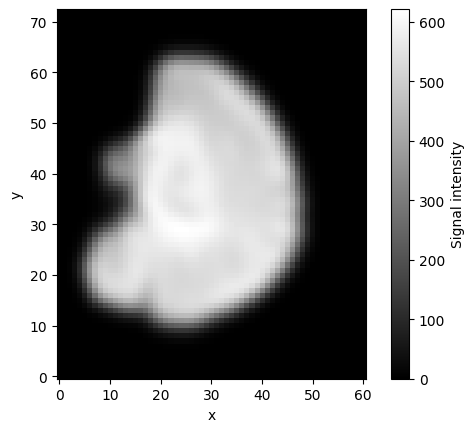

In [22]:
# Assume we want to just look at the 40th slice of the first timepoint
# of the fMRI (x = 40, t = 0)
mid_slice = fmri_data[40, :, :, 0]
print("Shape of mid slice: ", mid_slice.shape)

# Plot the slice
plt.imshow(mid_slice, cmap="gray", origin="lower")
plt.xlabel("x")
plt.ylabel("y")
plt.colorbar(label='Signal intensity')
plt.show()

In [23]:
# Assuming we instead want to look at the time seroes of a voxel and plot that
mid_voxel_time_series = fmri_data[40, 30, 30, :]
print("Shape of mid voxel time series: ", mid_voxel_time_series.shape)

Shape of mid voxel time series:  (261,)


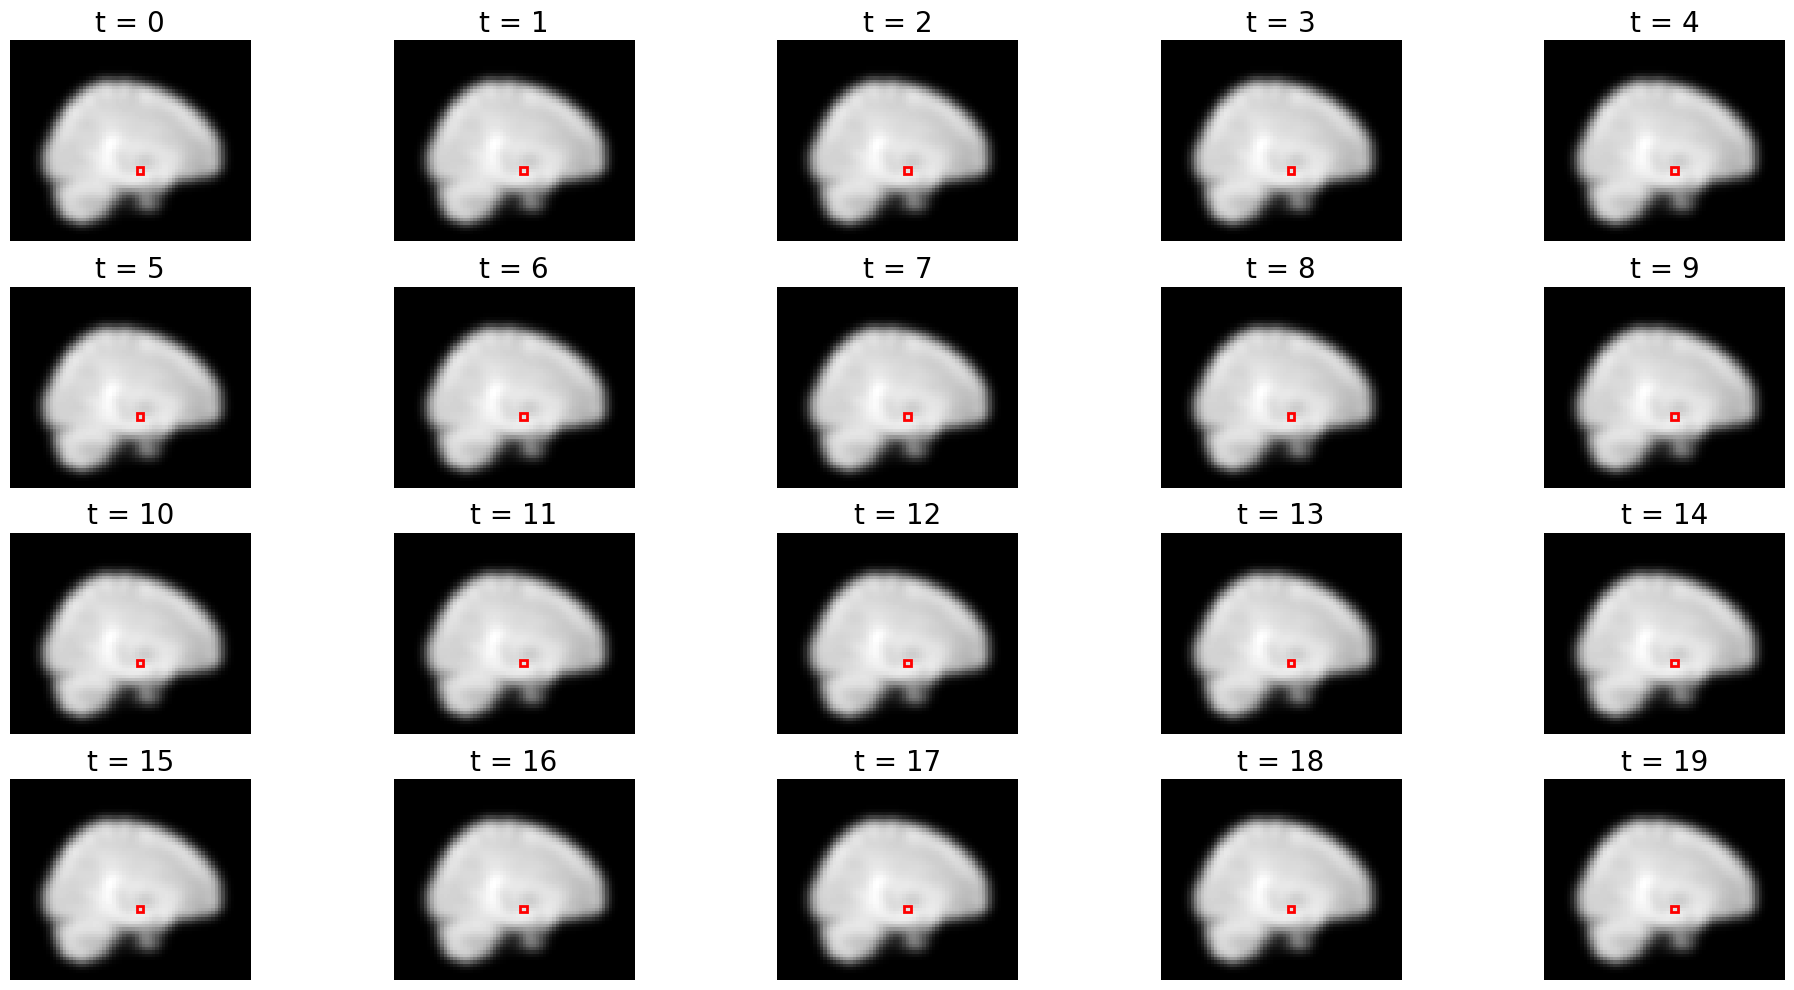

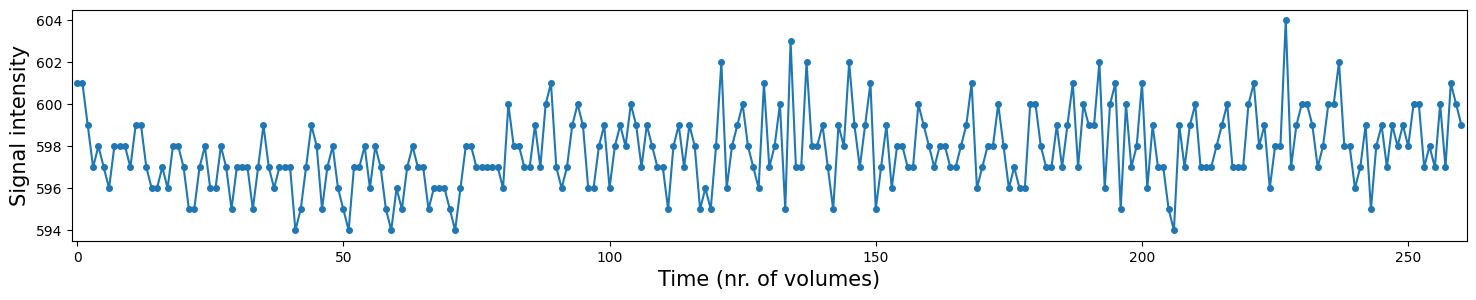

In [26]:
from matplotlib import patches

fig, axes = plt.subplots(ncols=5, nrows=4, figsize=(20, 10))  # 20 timepoints
# Loop over the first 20 volumes/timepoints
for t, ax in enumerate(axes.flatten()):    
    ax.imshow(fmri_data[39, :, :, t].T, cmap='gray', origin='lower')  # index with t!
    rect = patches.Rectangle((38, 20), 2, 2, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.axis('off')
    ax.set_title('t = %i' % t, fontsize=20)
fig.tight_layout()
plt.show()

# Now plot the time series of the voxel
plt.figure(figsize=(18, 3))
plt.plot(mid_voxel_time_series, 'o-', ms=4)
plt.xlim(-1, mid_voxel_time_series.size)
plt.ylabel('Signal intensity', fontsize=15)
plt.xlabel('Time (nr. of volumes)', fontsize=15)
plt.show()

In [19]:
from sc_functions import *
from tract_helpers import *
import matplotlib.pyplot as plt
from nilearn import image as nimg, plotting as nplot
import numpy as np
%matplotlib inline
import nibabel as nib

/home/hana_linux/anaconda3/envs/diss/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


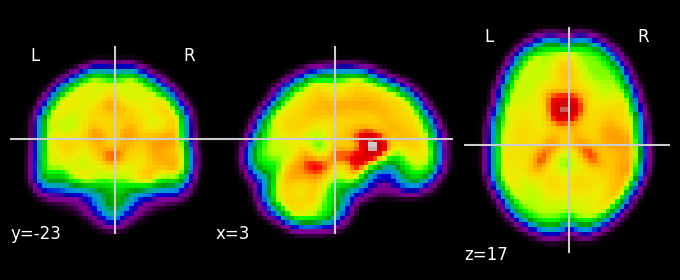

In [20]:
# Get the main paths
hpc = False
info_source, select_files, NIPYPE_OUTPUT_FOLDER = get_nipype_datasource(hpc)
# Look at the datasink output
datasink_dir = os.path.join(NIPYPE_OUTPUT_FOLDER, "datasink_dir")
# Get all the fmri files
fmri_files = glob_files(datasink_dir, "nii")
# Get the first fmri file
fmri_file = fmri_files[0]
# Load the fmri file
fmri = nimg.load_img(fmri_file)
# Get the 5th TR
fmri_5th_tr = fmri.slicer[:, :, :, 4]
nplot.view_img(fmri_5th_tr)
nplot.plot_epi(fmri_5th_tr)

Text(0, 0.5, 'Signal intensity')

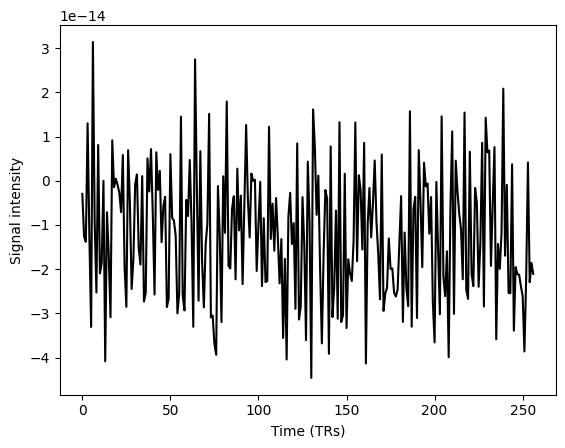

In [21]:
# Pick one voxel and look at the time series
fmri_one_voxel = fmri.slicer[3:4, 4:5, 30:31,:].get_fdata()
fmri_one_voxel = fmri_one_voxel.flatten()

# Make array countig from 0 to 257 as our axis
x_axis = np.arange(0, fmri_one_voxel.shape[0])
# Plot x and y data
plt.plot(x_axis, fmri_one_voxel, 'k')
# Label the axes
plt.xlabel('Time (TRs)')
plt.ylabel('Signal intensity')

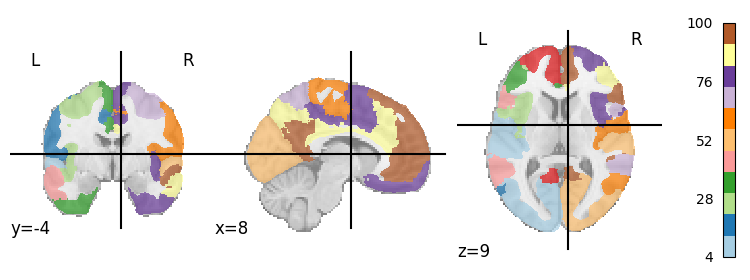

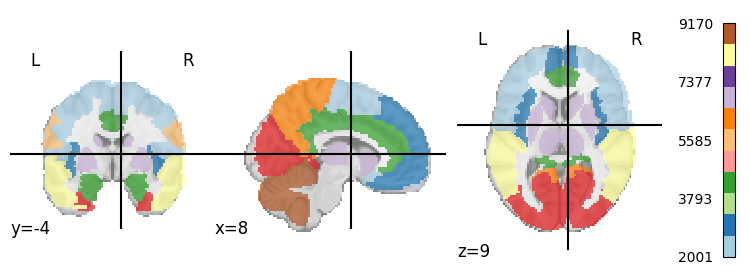

In [32]:
# Getting the atlas using nilearn
from nilearn import datasets
# Get the atlas
schaefer_atlas = datasets.fetch_atlas_schaefer_2018(n_rois=100)
aal_atlas = datasets.fetch_atlas_aal(version='SPM12')

# View the atlas image
cut_coords = (8, -4, 9)
colorbar = True
cmap = 'Paired'

# Plot the atlas
nplot.plot_roi(schaefer_atlas.maps, cut_coords=cut_coords, colorbar=colorbar, cmap=cmap)
nplot.plot_roi(aal_atlas.maps, cut_coords=cut_coords, colorbar=colorbar, cmap=cmap)

/home/hana_linux/anaconda3/envs/diss/lib/python3.11/site-packages/nilearn/regions/region_extractor.py:603: UserWarning: Data array used to create a new image contains 64-bit ints. This is likely due to creating the array with numpy and passing `int` as the `dtype`. Many tools such as FSL and SPM cannot deal with int64 in Nifti images, so for compatibility the data has been converted to int32.
  new_labels_img = new_img_like(labels_img, new_labels_data, affine=affine)


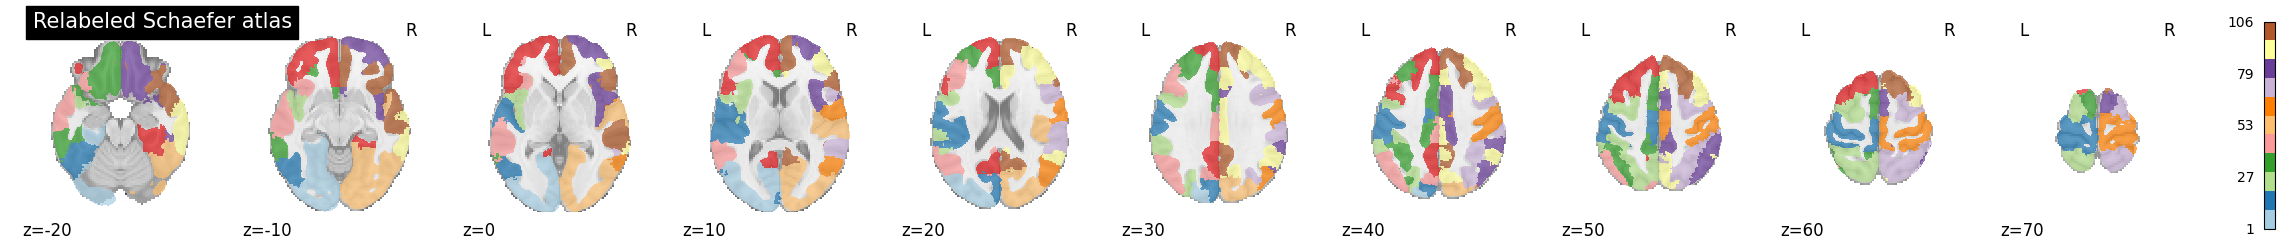

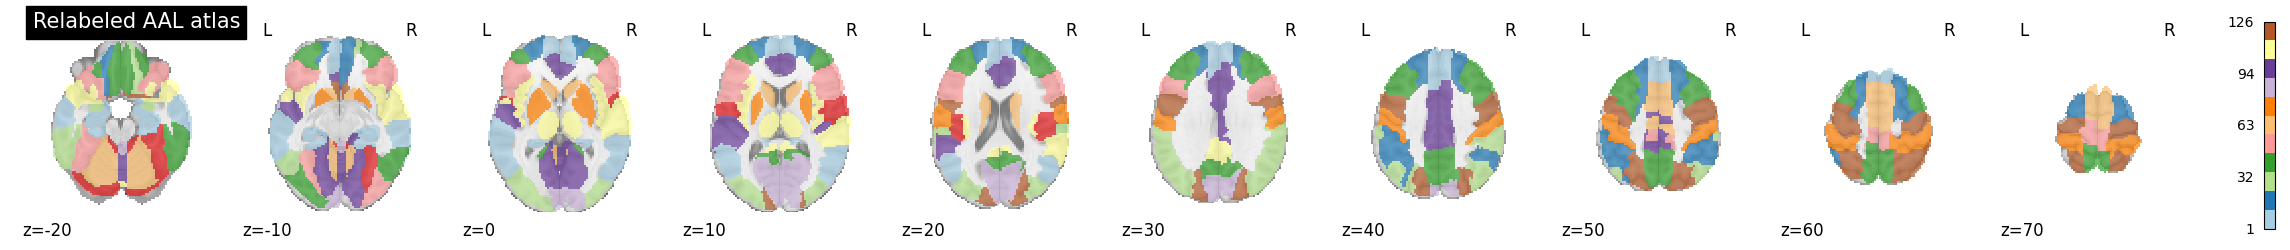

In [37]:
from nilearn.regions import connected_label_regions

# Deal with the spatial separation of the network 
# Currently, voxels in the same network are not necessarily adjacent
# We can use connected_label_regions to relabel the atlas such that all voxels
# in the same network are adjacent (aligned with the spatial structure of the brain
# based on spatial continuity)

# Schaefer Atlas
region_labels_schaefer = connected_label_regions(schaefer_atlas.maps)
nplot.plot_roi(region_labels_schaefer,
			cut_coords=(-20,-10,0,10,20,30,40,50,60,70),
			display_mode='z',
			colorbar=True,
			cmap='Paired',
			title='Relabeled Schaefer atlas')

# AAL Atlas
region_labels_aal = connected_label_regions(aal_atlas.maps)
nplot.plot_roi(region_labels_aal,
			cut_coords=(-20,-10,0,10,20,30,40,50,60,70),
			display_mode='z',
			colorbar=True,
			cmap='Paired',
			title='Relabeled AAL atlas')

Size of fmri data:  (45, 54, 45, 257)
Size of schaefer atlas:  (182, 218, 182)


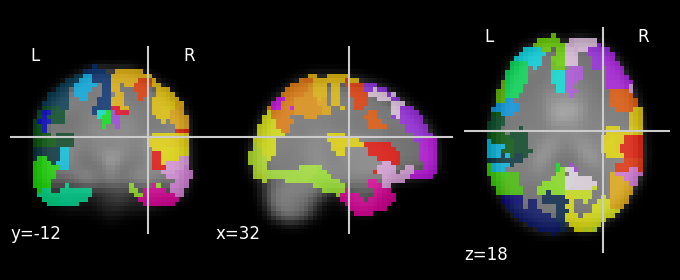

In [44]:
# Resample the atlas to the same resolution as the fmri data
from nilearn.image import resample_to_img

# Resample the atlas to the same resolution as the fmri data
print("Size of fmri data: ", fmri.shape)
print("Size of schaefer atlas: ", region_labels_schaefer.shape)
schaefer_atlas_3mm = resample_to_img(region_labels_schaefer, fmri, interpolation='nearest')
aal_atlas_3mm = resample_to_img(region_labels_aal, fmri, interpolation='nearest')

# Plot the resampled atlas
nplot.plot_roi(schaefer_atlas_3mm, fmri.slicer[:, :, :, 4])

In [63]:
# Extract the time series from the atlas
from nilearn import input_data

# Extract the time series from the atlas
masker = input_data.NiftiLabelsMasker(labels_img=schaefer_atlas_3mm, 
                                      standardize=True,
                                      memory='nilearn_cache',
                                      detrend=True,
                                      low_pass=0.1,
                                      high_pass=0.01,
                                      t_r=fmri.header.get_zooms()[-1])
time_series = masker.fit_transform(fmri)

# Get atlas labels and keep ones with non-zero values
atlas_labels = np.unique(schaefer_atlas_3mm.get_fdata().astype(int))
num_regions = len(atlas_labels)
print(atlas_labels)
print("Number of regions: ", num_regions)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  76  77  79  80  81  82  83  84  86  87  88  89  90  91  92  93
  94  96  97  98  99 100 101 102 103 104 105 106]
Number of regions:  102


In [64]:
# Create an array that has the number of rows matching number of timepoints and
# number of columns matching total number of regions
num_timepoints = fmri.shape[-1]
final_signal = np.zeros((num_timepoints, num_regions))
regions_kept = np.array(masker.labels_)
print(regions_kept)
# Fill columns matching labels with signal values
final_signal[:, regions_kept] = time_series

print("Shape of final signal: ", final_signal.shape)

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  76  77  79  80  81  82  83  84  86  87  88  89  90  91  92  93  94
  96  97  98  99 100 101 102 103 104 105 106]


IndexError: index 102 is out of bounds for axis 1 with size 102

In [66]:
from nilearn.connectome import ConnectivityMeasure

# Now we can use ConnectivityMeasure to calculate the correlation between all
# pairs of regions
correlation_measure = ConnectivityMeasure(kind='correlation')
full_correlation_matrix = correlation_measure.fit_transform([time_series])[0]
full_correlation_matrix.shape

/home/hana_linux/anaconda3/envs/diss/lib/python3.11/site-packages/nilearn/connectome/connectivity_matrices.py:495: FutureWarning: The default strategy for standardize is currently 'zscore' which incorrectly uses population std to calculate sample zscores. The new strategy 'zscore_sample' corrects this behavior by using the sample std. In release 0.13, the default strategy will be replaced by the new strategy and the 'zscore' option will be removed. Please use 'zscore_sample' instead.
  covariances_std = [


(101, 101)

<Axes: >

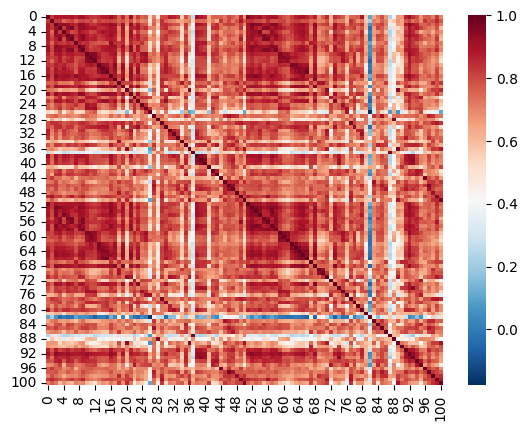

In [69]:
# Visualize the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(full_correlation_matrix, cmap='RdBu_r')